# Test new model

In [1]:
import torch
import torch.nn as nn 
from utils import get_mse_data, get_mse_train_loader

## Data

In [2]:
num_users, num_items, users_train, items_train, ratings_train, users_test, items_test, ratings_test, train_candidates, test_candidates = get_mse_data()

In [3]:
train_loader = get_mse_train_loader(users_train, items_train, ratings_train, shuffle=True)

In [4]:
len(train_loader)

98

## Model Config

In [5]:
from gcn.attention import AttGCN
device = "cuda" if torch.cuda.is_available() else "cpu"
n_factors = 10
model = AttGCN(num_users, num_items, n_factors)
model.to(device)
learning_rate, weight_decay = 0.01, 1e-5
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate, weight_decay=weight_decay)
loss_fn = nn.MSELoss()
print(f"device: {device}, n_factors: {n_factors}, learning_rate: {learning_rate}, weight_decay: {weight_decay}")

device: cuda, n_factors: 10, learning_rate: 0.01, weight_decay: 1e-05


## Train

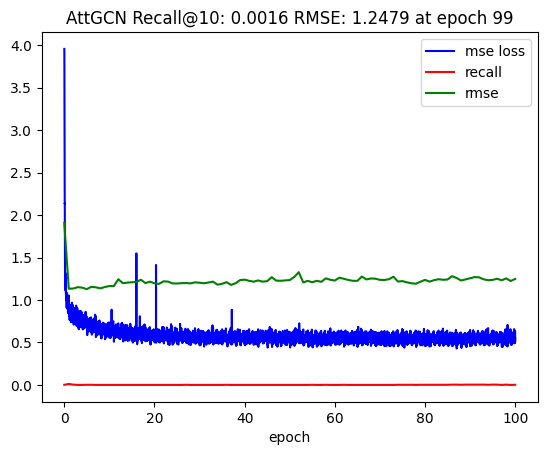

AttGCN Recall@10: 0.0016 RMSE: 1.2479 at epoch 99


In [6]:
from gcn.train import evaluate_ranking, evaluate_rating
from gcn.visualize import Animator
ani = Animator()
num_epochs = 100
topk = 10
train_epoch_perc = []
train_loss = []
epoch_list = []
rmse_list = []
recall_list = []

with torch.no_grad():
    recall = evaluate_ranking(
        model,
        test_candidates,
        train_candidates,
        num_users,
        num_items,
        top_k = topk
    )
    recall_list.append(recall)
    rmse = evaluate_rating(
        model,
        users_test, 
        items_test, 
        ratings_test
    )
    rmse_list.append(rmse)
    epoch_list.append(0)

for epoch in range(num_epochs):
    for batch, values in enumerate(train_loader):
        users, items, ratings = values[0].to(device), values[1].to(device), values[2].to(device)
        # Forward pass
        scores = model(users, items)
        loss = loss_fn(scores, ratings.float())
        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # if batch % 64 == 0:
        train_epoch_perc.append((batch+1)/ len(train_loader) + epoch)
        train_loss.append(loss.item())
        print(f'step:{batch+1}/{len(train_loader)} epoch:{epoch}/{num_epochs} loss:{train_loss[-1]}')


    with torch.no_grad():
        recall = evaluate_ranking(
            model,
            test_candidates,
            train_candidates,
            num_users,
            num_items,
            top_k = topk
        )
        recall_list.append(recall)
        rmse = evaluate_rating(
            model,
            users_test, 
            items_test, 
            ratings_test
        )
        rmse_list.append(rmse)
        epoch_list.append(epoch+1)


    ani.clear()
    ani.ax.plot(train_epoch_perc, train_loss, color='b', label='mse loss')
    ani.ax.plot(epoch_list, recall_list, color='r', label='recall')
    ani.ax.plot(epoch_list, rmse_list, color='g', label='rmse')
    ani.ax.set_xlabel('epoch')
    ani.ax.legend()
    ani.ax.set_title(f'AttGCN Recall@{topk}: {recall_list[-1]:.4f} RMSE: {rmse_list[-1]:.4f} at epoch {epoch}')
    ani.render()

    print(f'AttGCN Recall@{topk}: {recall_list[-1]:.4f} RMSE: {rmse_list[-1]:.4f} at epoch {epoch}')

ani.close()

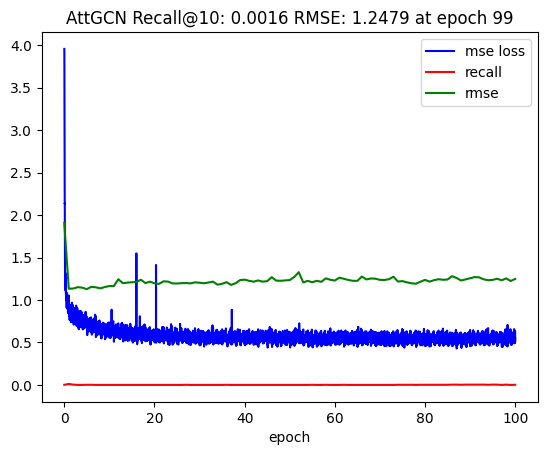

In [7]:
import matplotlib.pyplot as plt
plt.plot(train_epoch_perc, train_loss, color='b', label='mse loss')
plt.plot(epoch_list, recall_list, color='r', label='recall')
plt.plot(epoch_list, rmse_list, color='g', label='rmse')
plt.xlabel("epoch")
plt.legend()
plt.title(f'AttGCN Recall@{topk}: {recall_list[-1]:.4f} RMSE: {rmse_list[-1]:.4f} at epoch {epoch}')
plt.savefig(f'./images/AttGCN Recall@{topk}: {recall_list[-1]:.4f} RMSE: {rmse_list[-1]:.4f} at epoch {epoch}.png')
plt.show()

In [8]:
recall_list

[0.001639344262295082,
 0.011475409836065573,
 0.003278688524590164,
 0.0,
 0.0,
 0.001639344262295082,
 0.001639344262295082,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.001639344262295082,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.001639344262295082,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.001639344262295082,
 0.0,
 0.0,
 0.001639344262295082,
 0.0,
 0.0,
 0.0,
 0.001639344262295082,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.001639344262295082,
 0.001639344262295082,
 0.001639344262295082,
 0.001639344262295082,
 0.0,
 0.001639344262295082,
 0.001639344262295082,
 0.001639344262295082,
 0.001639344262295082,
 0.001639344262295082,
 0.001639344262295082,
 0.001639344262295082,
 0.003278688524590164,
 0.003278688524590164,
 0.001639344262295082,
 0.003278688524590164,
 0.003278688524590164,
 0.003278688

In [9]:
rmse_list

[1.90895838711017,
 1.1330611909636463,
 1.13540872810225,
 1.151177854234424,
 1.1453377027457856,
 1.1280483695339392,
 1.1556711036476657,
 1.1495523555923783,
 1.1373634738524654,
 1.1529250925351535,
 1.1644648938126556,
 1.1640078640603333,
 1.2444135764717656,
 1.1978393474449287,
 1.2053151199039374,
 1.2088209297490178,
 1.213225977142789,
 1.2386916289834051,
 1.1990858867990204,
 1.2160489889898976,
 1.1966822137770177,
 1.1892894012069994,
 1.219934279360141,
 1.2168924407414483,
 1.1955562168562273,
 1.194625457581571,
 1.1983614165066556,
 1.2003334158396213,
 1.1955873260704355,
 1.208005148068252,
 1.2032975407522886,
 1.197086239891007,
 1.2066809383535395,
 1.2160686438472386,
 1.1801265884645704,
 1.1913317547630977,
 1.2101394484691468,
 1.1777384237596245,
 1.1976923967593887,
 1.2345854181501021,
 1.2396590693228107,
 1.2258346244516496,
 1.215920072698791,
 1.2305417478191936,
 1.2161329487915178,
 1.2219074625449384,
 1.2690838304129963,
 1.2284560439273244,
 1.

In [10]:
# max(recall_list), min(rmse_list) 
print(f'AttGCN Max Recall@{topk}: {max(recall_list):.4f} at epoch {recall_list.index(max(recall_list))}')
print(f'AttGCN Min RMSE: {min(rmse_list):.4f} at epoch {rmse_list.index(min(rmse_list))}')

AttGCN Max Recall@10: 0.0115 at epoch 1
AttGCN Min RMSE: 1.1280 at epoch 5
